# Gesture Recognition Case Study
-----
### Problem Statement: 

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Thumbs up:  Increase the volume
Thumbs down: Decrease the volume
Left swipe: 'Jump' backwards 10 seconds
Right swipe: 'Jump' forward 10 seconds  
Stop: Pause the movie

----
 

In [5]:
import numpy as np
import os
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
from cv2 import imread, resize
import datetime
import os
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
import zipfile as zf

In [7]:
#files = zf.ZipFile("Project_data.zip", 'r')
#files.extractall('Project_data')

In [8]:
import os
os.environ['PYTHONHASHSEED']="30"
np.random.seed(50)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)
from keras import backend as K

In [9]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In this segment, extract the names of the training and validation folders while also configuring the `batch_size`. It's important to mention that the batch size is optimized to fully leverage the GPU capacity. The approach involves progressively increasing the batch size until an error is encountered, ensuring efficient GPU utilization.

In [10]:
#train_doc, val_doc = get_data('Project_data/', ablation=None)
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32 
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [14]:
def generator(source_path, folder_list, batch_size, is_train=False, augmentation=False, debug=False):
    img_idx = seq_idx
    x, y, z = len(img_idx), dim_x, dim_y
    
    while True:
        t = np.concatenate([np.random.permutation(folder_list)] * (2 if is_train and augmentation else 1))
        num_batches = len(t) // batch_size + (1 if len(t) % batch_size != 0 else 0)
        
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3))
            batch_labels = np.zeros((batch_size, 5))
            
            for folder in range(batch_size):
                folder_idx = folder + (batch * batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                
                imgs = os.listdir(os.path.join(source_path, folder_str.split(';')[0]))
                
                aug_type = np.random.randint(0, 5) if is_train and augmentation and np.random.randint(0, 2) == 1 else None

                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(source_path, folder_str.strip().split(';')[0], imgs[item])
                    image = img_to_array(load_img(image_path)).astype(np.float32)

                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    image = image[:, :image.shape[0]] if image.shape[1] > image.shape[0] else image[:image.shape[1], :]

                    resized_im = resize(image, (y, z))

                    if aug_type is not None:
                        aug = ImageDataGenerator()
                        if aug_type == 4:  # Brightness enhancement
                            aug_brightness = np.random.uniform(1.0, 1.5)
                            aug = ImageDataGenerator(brightness_range=(aug_brightness, aug_brightness))

                        resized_im = aug.random_transform(resized_im)

                    if debug:
                        plt.subplot(2, x, idx + x + 1)
                        plt.imshow(resized_im)

                    batch_data[folder, idx] = resized_im / 255

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train' 
val_path =  'Project_data/val'

num_train_sequences = len(train_doc)
print('Count of training sequences   =', num_train_sequences)
num_val_sequences = len(val_doc)
print('Count of validation sequences =', num_val_sequences)
num_epochs = 50
print ('Number of epochs              =', num_epochs)

Count of training sequences   = 663
Count of validation sequences = 100
Number of epochs              = 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

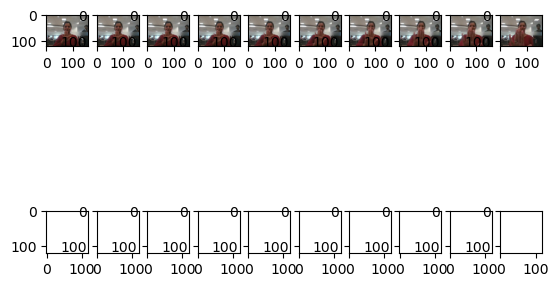

In [16]:
# testing generative 
test_gen = generator(train_path, train_doc, 1, is_train = True, augmentation = True, debug = True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [17]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)


## Model creation

In [18]:
model = Sequential()

# Convolutional layers with TimeDistributed
model.add(TimeDistributed(Conv2D(8, (3, 3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu')))
model.add(BatchNormalization())

# ConvLSTM2D layer
model.add(ConvLSTM2D(8, kernel_size=3, return_sequences=False))
model.add(BatchNormalization())

# TimeDistributed Dense layer
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

# Global Average Pooling and Dense layers
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [19]:
optimiser = optimizers.Adam(lr=0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 118, 118, 8)   224       
 ributed)                                                        
                                                                 
 batch_normalization (Batch  (None, 10, 118, 118, 8)   32        
 Normalization)                                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 116, 116, 16   1168      
 stributed)                  )                                   
                                                                 
 batch_normalization_1 (Bat  (None, 10, 116, 116, 16   64        
 chNormalization)            )                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)       6

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [20]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True)
val_generator = generator(val_path, val_doc, batch_size)

In [21]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [23]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50



21/21 [==============================] - ETA: 0s - loss: 1.4806 - categorical_accuracy: 0.3557
Epoch 1: saving model to model_init_2024-01-3114_20_08.435310\model-00001-1.48064-0.35565-1.25356-0.16406.h5
21/21 [==============================] - 140s 6s/step - loss: 1.4806 - categorical_accuracy: 0.3557 - val_loss: 1.2536 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.2577 - categorical_accuracy: 0.5193
Epoch 2: saving model to model_init_2024-01-3114_20_08.435310\model-00002-1.25767-0.51935-1.23940-0.13281.h5
21/21 [==============================] - 80s 4s/step - loss: 1.2577 - categorical_accuracy: 0.5193 - val_loss: 1.2394 - val_categorical_accuracy: 0.1328 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.0947 - categorical_accuracy: 0.5833
Epoch 3: saving model to model_init_2024-01-3114_20_08.435310\model-00003-1.09475-0.58333-1.24101-0.14844.h5
21/21 [==========================

21/21 [==============================] - 76s 4s/step - loss: 0.3146 - categorical_accuracy: 0.8943 - val_loss: 1.8405 - val_categorical_accuracy: 0.5625 - lr: 0.0010
Epoch 23/50
21/21 [==============================] - ETA: 0s - loss: 0.3025 - categorical_accuracy: 0.8914
Epoch 23: saving model to model_init_2024-01-3114_20_08.435310\model-00023-0.30251-0.89137-1.37207-0.60156.h5
21/21 [==============================] - 93s 4s/step - loss: 0.3025 - categorical_accuracy: 0.8914 - val_loss: 1.3721 - val_categorical_accuracy: 0.6016 - lr: 0.0010
Epoch 24/50
21/21 [==============================] - ETA: 0s - loss: 0.2731 - categorical_accuracy: 0.9092
Epoch 24: saving model to model_init_2024-01-3114_20_08.435310\model-00024-0.27314-0.90923-1.41700-0.53125.h5
21/21 [==============================] - 93s 4s/step - loss: 0.2731 - categorical_accuracy: 0.9092 - val_loss: 1.4170 - val_categorical_accuracy: 0.5312 - lr: 0.0010
Epoch 25/50
21/21 [==============================] - ETA: 0s - loss:

Epoch 44/50
21/21 [==============================] - ETA: 0s - loss: 0.2506 - categorical_accuracy: 0.8988
Epoch 44: saving model to model_init_2024-01-3114_20_08.435310\model-00044-0.25057-0.89881-0.75817-0.74219.h5
21/21 [==============================] - 175s 8s/step - loss: 0.2506 - categorical_accuracy: 0.8988 - val_loss: 0.7582 - val_categorical_accuracy: 0.7422 - lr: 0.0010
Epoch 45/50
21/21 [==============================] - ETA: 0s - loss: 0.2610 - categorical_accuracy: 0.8824
Epoch 45: saving model to model_init_2024-01-3114_20_08.435310\model-00045-0.26104-0.88244-0.52333-0.60156.h5
21/21 [==============================] - 135s 6s/step - loss: 0.2610 - categorical_accuracy: 0.8824 - val_loss: 0.5233 - val_categorical_accuracy: 0.6016 - lr: 0.0010
Epoch 46/50
21/21 [==============================] - ETA: 0s - loss: 0.2338 - categorical_accuracy: 0.8943
Epoch 46: saving model to model_init_2024-01-3114_20_08.435310\model-00046-0.23382-0.89435-0.58527-0.54688.h5
21/21 [========